### Assignment #2

Completed by Jing Wang, Alexander Moshchev, Saarthak Kataria, Suchitra Nayak, Yiting Yuan

In [2]:
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import StandardScaler
import numpy as np

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import svm
from sklearn.model_selection import KFold, validation_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time
from matplotlib import cm
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Task 1

Based on the program developed in the lecture, implement a nonlinear
Kernel classification based on SVM for polynomial kernels (poly) and for
Gaussian Kernels, i.e., radial base functions (rbf). Apply the analysis to a
database of your choice, using the python code as provided (or your own).

Choose (and justify in a small text paragraph) two metrics to optimize for,
such as accuracy, precision, recall, f1, f0.5, and f2 score, and determine
which combo of hyperparameters maximizes each of the two scores you
chose. It would be on you if you want to use GridSearch (as used in the
provided code), RandomSearch, or other methods such as hyperopt. 

It is also on you to try other kernels of your choice. A 2-hyperparameter scan
is sufficient. Of course, you are free to scan more parameters, if useful and
interesting and doable for you. Do not forget to comment your choices
and results in short take-home statements. Data can be found everywhere,
e.g., at https://archive.ics.uci.edu/ml/index.php. No submissions based on
cancer or wine data! Have fun. It will be.

### 1. Dataset Importing and Preprocessing

After some trial and error with different data sets, we have chosen to use the "Rice (Cammeo and Osmancik)" 
dataset from the UCI machine learning repository as - 
we will see in the next step - it has quite balanced classes.

This dataset has 3810 instances and 8
attributes, including the "target" variable indicating the class of the rice.
The objective for this data set is to correctly predict the class type of the rice

further information on the data set can be found here: https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik

Among  the certified rice grown in TURKEY,  the  Osmancik species, which has a large planting area since 1997 and the Cammeo species grown since 2014 have been selected for the study.  When  looking  at  the  general  characteristics  of  Osmancik species, they have a wide, long, glassy and dull appearance.  When looking at the general characteristics of the Cammeo species, they have wide and long, glassy and dull in appearance.  A total of 3810 rice grain's images were taken for the two species, processed and feature inferences were made. 7 morphological features were obtained for each grain of rice. 

In [3]:
#fetching data
rice_cammeo_and_osmancik = fetch_ucirepo(id=545)
#features
X = rice_cammeo_and_osmancik.data.features
#target
y = rice_cammeo_and_osmancik.data.targets

X

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024
...,...,...,...,...,...,...,...
3805,11441,415.858002,170.486771,85.756592,0.864280,11628,0.681012
3806,11625,421.390015,167.714798,89.462570,0.845850,11904,0.694279
3807,12437,442.498993,183.572922,86.801979,0.881144,12645,0.626739
3808,9882,392.296997,161.193985,78.210480,0.874406,10097,0.659064


In [4]:
data = pd.concat([X, y], axis=1)  # Combine features X and target y into one DataFrame.
selected_data = data.sample(n=500, random_state=42)  # Randomly sample 500 rows with reproducibility.
X_selected = selected_data.drop(columns='Class')  # Extract sampled features excluding the target column.
y_selected = selected_data['Class']  # Extract the target variable from the sampled data.


In [5]:
#transforming the target variables into binary 0 and 1 calssification from string values 
le = LabelEncoder()
y_selected = le.fit_transform(y_selected)

#checking how balanced the data set is 
print('the portion of Cammeo rice is ' + str(round(sum(y_selected) / len(y_selected) * 100,4)) + '%')

# Split into train and test set and normalize data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, stratify=y_selected, random_state=42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

the portion of Cammeo rice is 54.2%


### Optimization Metrics

We chose the following metrics to optimize for:

$f2$ score
$f0.5$ score
It's important to highlight that for the f-scores, we selected betas of .5 and 2. We choose f2 and f0.5 score as optimization objectives because we aim to balance precision and recall, acknowledging their trade-off in the process. More precision means more confidence in identifying the specific rice variety accurately, crucial for ensuring the purity of rice classifications. Higher recall ensures that we minimize the risk of overlooking any particular variety, important for comprehensive classification coverage.

F2 score pays recall twice as important as presision, while f0.5 pays precision twice important as recall.
Moving forward, we will develop two f-beta scorers. This will enable us to assess and select the most appropriate models in subsequent steps.

The selected data(500 samples) is balanced

In [6]:
# fbeta_score: the F-beta score is the weighted harmonic mean of precision and recall, taking into account a beta parameter
# that determines the weight of recall in the combined score. The F-beta score reaches its optimal value at 1 (perfect precision and recall)
# and its worst value at 0.
def f2_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    #the beta value of 2 indicates that recall is considered 
    # twice as important as precision. This scoring method is particularly advantageous in situations where missing 
    # a positive instance has a higher cost than incorrectly identifying a negative instance as positive. The 'pos_label=0' 
    # parameter specifies that the class labeled '0' is treated as the positive class in this binary classification scenario.
    return fbeta_score(y_true, y_pred, beta = 2, pos_label = 0, average = 'binary')

f2 = make_scorer(f2_scorer, greater_is_better=True)

# here for question b: make f05 a valid validation
def f05_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    # This scorer function calculates the F0.5 score, emphasizing precision over recall with a beta value of 0.5. 
    # This means precision is considered twice as significant as recall, suitable for contexts where false positives 
    # are more costly than false negatives.
    return fbeta_score(y_true, y_pred, beta = 0.5, pos_label = 0, average = 'binary')

f05 = make_scorer(f05_scorer, greater_is_better = True)

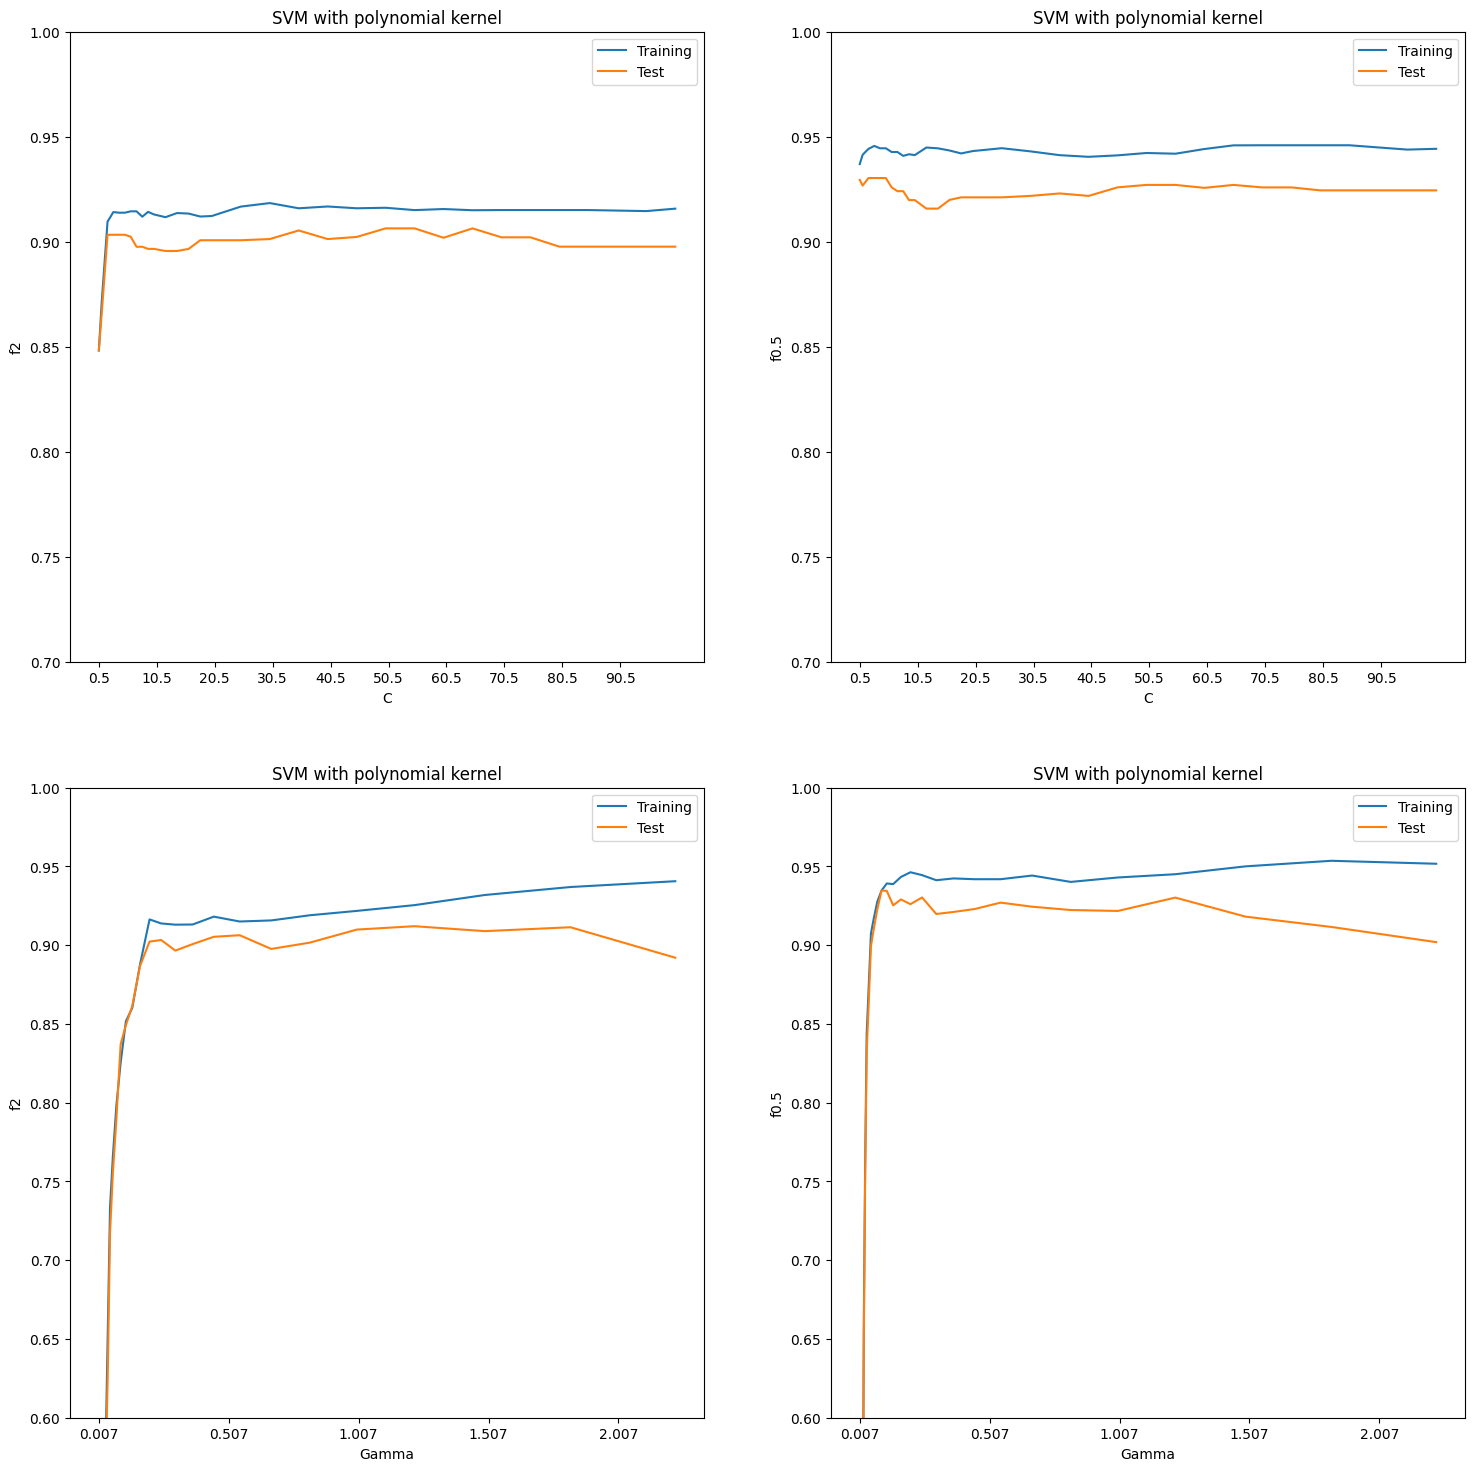

In [8]:
# SVM with polynomial kernel
# for score = f2 and f0.5
# hyperparameters gamma, C 
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#
def plot_poly_curve(gammas = 'auto', Cs = 1, degrees = 3, scoring = f2): # by default
    
    num_splits = 5 # use of k-fold is good
    kfold = KFold(n_splits = 5) # ,random_state = 0) 
    
    if type(Cs) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'poly', gamma = gammas, degree = degrees)
        num_values = len(Cs)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name="C", param_range=Cs, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'C'
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs
        ylim = [0.7, 1]
    elif type(gammas) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'poly', degree = degrees, C = Cs)
        num_values = len(gammas)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name="gamma", param_range=gammas, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'Gamma'
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas
        ylim = [0.6, 1]
    else:
        raise TypeError

    train_scores_poly = pd.DataFrame(data = train_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 
    valid_scores_poly = pd.DataFrame(data = valid_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores_poly.mean(axis=1), label = 'Training')
    plt.plot(Xs, valid_scores_poly.mean(axis=1), label = 'Test')
    plt.xlabel(xlabel)
    if scoring == f2:
        plt.ylabel('f2')
    elif scoring == f05:
        plt.ylabel('f0.5')
    else:
        plt.ylabel('scoring')
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title('SVM with polynomial kernel')
    plt.legend()

    
plt.figure(figsize = (18, 18))

Cs = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                  
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5)))

gammas = np.exp(np.arange(-5, 1, 0.2))

plt.subplot(2, 2, 1)
plot_poly_curve(Cs = Cs)
plt.subplot(2, 2, 2)
plot_poly_curve(Cs = Cs, scoring = f05)
plt.subplot(2, 2, 3)
plot_poly_curve(gammas = gammas)
plt.subplot(2, 2, 4)
plot_poly_curve(gammas = gammas, scoring = f05)

plt.show()

For polynomial kernel, where gamma is constant -  the model's performance on the training set remains relatively stable and high, suggesting that overfitting is not a significant issue for the range of C values chosen as the regularization parameter C increases

For polynomial kernel, where c is constant - the model performs bad, when gamma is small(underfitting). The performance gets better with increase of gamma at beginning. But large gamma will result in overfiiting, so at the end, when gamma is large, there is higher score in traning data but lower score in test data due to overfitting.

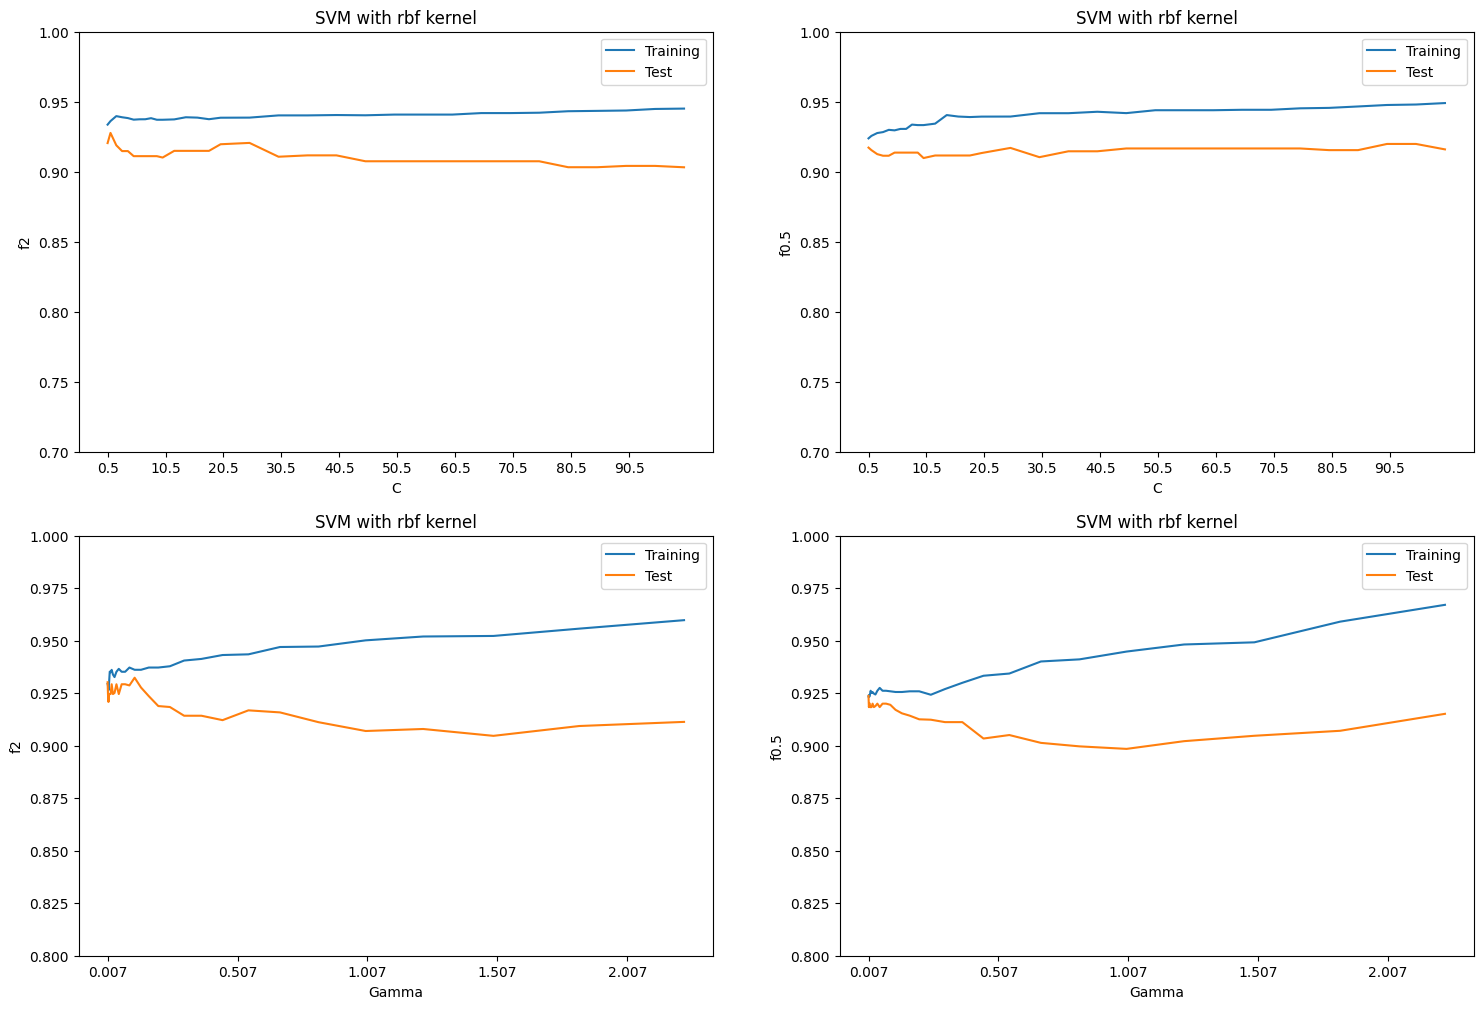

In [10]:

def plot_rbf_curve(gammas = 'auto', Cs = 1, scoring = f2): # by default
    
    num_splits = 5 # use of k-fold is good
    kfold = KFold(n_splits = 5) # ,random_state = 0) 
    
    if type(Cs) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'rbf', gamma = gammas)
        num_values = len(Cs)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name="C", param_range=Cs, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'C'
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs
        ylim = [0.7, 1]
    elif type(gammas) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'rbf', C = Cs)
        num_values = len(gammas)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name="gamma", param_range=gammas, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'Gamma'
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas
        ylim = [0.8, 1]
    else:
        raise TypeError

    train_scores_poly = pd.DataFrame(data = train_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 
    valid_scores_poly = pd.DataFrame(data = valid_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores_poly.mean(axis=1), label = 'Training')
    plt.plot(Xs, valid_scores_poly.mean(axis=1), label = 'Test')
    plt.xlabel(xlabel)
    if scoring == f2:
        plt.ylabel('f2')
    elif scoring == f05:
        plt.ylabel('f0.5')
    else:
        plt.ylabel('scoring')
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title('SVM with rbf kernel')
    plt.legend()

    
plt.figure(figsize = (18, 12))

Cs = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                  
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5)))
#gammas = np.arange(0.008, 0.051, 0.002)
gammas = np.exp(np.arange(-5, 1, 0.2))

plt.subplot(2, 2, 1)
plot_rbf_curve(Cs = Cs)
plt.subplot(2, 2, 2)
plot_rbf_curve(Cs = Cs, scoring = f05)
plt.subplot(2, 2, 3)
plot_rbf_curve(gammas = gammas)
plt.subplot(2, 2, 4)
plot_rbf_curve(gammas = gammas, scoring = f05)


plt.show()

The plots indicate that the SVM with an RBF kernel demonstrates stable and high training and test scores across a range of C and gamma values for both the f2 and f0.5 scores. This suggests the model is not overly sensitive to changes in these hyperparameters within the tested ranges and generalizes well to unseen data. There are no signs of overfitting, as the test scores are close to the training scores across the board.

### 3. Fitting the SVM to the data with different kernel functions using Grid Search Method

In [12]:
start = time.time()

param_grid = {'kernel' : ['poly', 'rbf'],
              'C' : [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100],
              'gamma' : [1/X_train.shape[1], 0.01, 0.1, 1, 10]
              }              

scoring = {
           'f2' : f2,
           'f0.5' : f05
           }

svm_ = svm.SVC() #random_state = 0)

CV_svm = GridSearchCV(estimator = svm_, param_grid = param_grid, cv = 5, 
                      scoring = scoring, refit = 'f2')

CV_svm.fit(X_train, y_train)


time_spend = time.time() - start
print('time spent: ', time_spend)

time spent:  1347.5884511470795


In [13]:
# a DataFrame to keep track of the results
params_ = CV_svm.cv_results_['params']
result = {k : [dic[k] for dic in params_] for k in params_[0]}
cln = ['kernel', 'C', 'gamma']

for i in [ 'f0.5', 'f2']:
    result['mean_test_' + i] = CV_svm.cv_results_['mean_test_' + i]
    result['std_test_' + i] = CV_svm.cv_results_['std_test_' + i]
    cln.append('mean_test_' + i)

results = pd.DataFrame(result)

In [23]:
results.loc[results.kernel == 'rbf', 'degree'] = np.nan
results.loc[results.kernel == 'poly', 'degree'] = np.nan

results.drop_duplicates(inplace = True) 
results_sorted2 = results.sort_values('mean_test_f2', ascending = False)
display(results_sorted2.loc[:,cln].head(10))

,kernel,C,gamma,mean_test_f0.5,mean_test_f2
45,rbf,1.0,0.100000,0.920616,0.926256
53,rbf,10.0,0.010000,0.916555,0.925257
73,rbf,100.0,0.010000,0.916181,0.924951
63,rbf,50.0,0.010000,0.916181,0.924951
21,rbf,0.1,0.142857,0.922488,0.922409
31,rbf,0.5,0.142857,0.918955,0.921591
35,rbf,0.5,0.100000,0.918955,0.921591
43,rbf,1.0,0.010000,0.918955,0.921591
41,rbf,1.0,0.142857,0.911237,0.919601
25,rbf,0.1,0.100000,0.921201,0.918050


For top ten mean f2 score, rbf kernel are dominated means it performs much more better than polynomial kernel for this dataset. and gamma is relatively small from 
0.01 to 0.1. C is relatively larger. in the context of Support Vector Machines (SVMs) a larger value for the hyperparameter C corresponds to less regularization. 

The table shows SVM model performance with an RBF kernel, with varying C and gamma parameters, consistently achieving high mean test scores for both f0.5 and f2 metrics, indicating effective model performance across different levels of regularization and kernel scaling.

In [15]:
display(results_sorted2.tail(10))

,C,gamma,kernel,mean_test_f0.5,std_test_f0.5,mean_test_f2,std_test_f2,degree
7,0.001,1.000000,rbf,0.0,0.0,0.0,0.0,NaN
9,0.001,10.000000,rbf,0.0,0.0,0.0,0.0,NaN
22,0.100,0.010000,poly,0.0,0.0,0.0,0.0,NaN
19,0.010,10.000000,rbf,0.0,0.0,0.0,0.0,NaN
12,0.010,0.010000,poly,0.0,0.0,0.0,0.0,NaN
13,0.010,0.010000,rbf,0.0,0.0,0.0,0.0,NaN
32,0.500,0.010000,poly,0.0,0.0,0.0,0.0,NaN
29,0.100,10.000000,rbf,0.0,0.0,0.0,0.0,NaN
17,0.010,1.000000,rbf,0.0,0.0,0.0,0.0,NaN
1,0.001,0.142857,rbf,0.0,0.0,0.0,0.0,NaN


For the worst ten mean f2 score, C is very small, much less than 1,while gamma still small. Hence, C plays more important role here. The table shows that certain parameter combinations for an SVM model, particularly with very low values of C or specific settings of gamma, resulted in zero mean test scores for both the f0.5 and f2 metrics, indicating that these models failed to correctly classify any of the positive class instances in the cross-validation process.

In [16]:
results.loc[results.kernel == 'rbf', 'degree'] = np.nan
results.loc[results.kernel == 'poly', 'degree'] = np.nan

results.drop_duplicates(inplace = True) 
results_sorted2 = results.sort_values('mean_test_f0.5', ascending = False)
display(results_sorted2.loc[:,cln].head(10))

,kernel,C,gamma,mean_test_f0.5,mean_test_f2
23,rbf,0.100,0.010000,0.942510,0.910895
54,poly,10.000,0.100000,0.932731,0.904600
16,poly,0.010,1.000000,0.932731,0.904600
60,poly,50.000,0.142857,0.929977,0.908254
40,poly,1.000,0.142857,0.929141,0.869458
6,poly,0.001,1.000000,0.928985,0.843791
44,poly,1.000,0.100000,0.928985,0.843791
26,poly,0.100,1.000000,0.928503,0.903355
74,poly,100.000,0.100000,0.928503,0.903355
50,poly,10.000,0.142857,0.928089,0.903275


This table displays SVM model results with both RBF and polynomial kernels, indicating that RBF with certain settings slightly outperforms polynomial on the f0.5 score, but polynomial kernels with higher C values achieve competitive or better f2 scores, highlighting a trade-off between precision and recall across different kernel types and hyperparameter settings.

In [17]:
display(results_sorted2.tail(10))

,C,gamma,kernel,mean_test_f0.5,std_test_f0.5,mean_test_f2,std_test_f2,degree
32,0.500,0.010000,poly,0.0,0.0,0.0,0.0,NaN
19,0.010,10.000000,rbf,0.0,0.0,0.0,0.0,NaN
9,0.001,10.000000,rbf,0.0,0.0,0.0,0.0,NaN
7,0.001,1.000000,rbf,0.0,0.0,0.0,0.0,NaN
5,0.001,0.100000,rbf,0.0,0.0,0.0,0.0,NaN
4,0.001,0.100000,poly,0.0,0.0,0.0,0.0,NaN
3,0.001,0.010000,rbf,0.0,0.0,0.0,0.0,NaN
2,0.001,0.010000,poly,0.0,0.0,0.0,0.0,NaN
1,0.001,0.142857,rbf,0.0,0.0,0.0,0.0,NaN
22,0.100,0.010000,poly,0.0,0.0,0.0,0.0,NaN


The table shows that the SVM models with certain low C values and various gamma settings consistently failed to perform well, resulting in zero mean test scores for both f0.5 and f2 metrics, indicating inadequate model performance with these hyperparameter configurations.

### Take Home Message:

The gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors, while a smaller gamma value leads to a larger influence radius. When gamma is small (i.e., large influence range), the model treats all samples as having similar influence ranges. When gamma is large (i.e., small influence range), the model focuses more on the data near individual sample points. 

The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words C behaves as a regularization parameter in the SVM.

For sorting rice types, the SVM models we tested do a pretty good job when we adjust the controls (C and gamma) just right. Models with higher C values that reflect less regularization tend to work better. But if we set C too low, the model can't learn enough to make good predictions. We have to look at both f0.5 and f2 scores because they tell us how accurate our model is and how many rice types it can correctly identify. The takeaway is that tweaking these controls is important for the best sorting of the rice.

## Task 2

In [ ]:
# Regularization: Ridge, LASSO, Elastic Net
# based on D. Bette that was based on J. Nagler
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### Define models

In [ ]:
# Min: ||y - Xw||^2_2 + alpha * ||w||^2_2
def do_ridge(lambdaaa,X_train,y_train,X_test,y_test):
    ridge = Ridge(alpha=lambdaaa, max_iter=int(10e5))
    ridge.fit(X_train,y_train)
    ridge_train_score=ridge.score(X_train,y_train)
    ridge_test_score=ridge.score(X_test,y_test)
    ridge_num_features = np.sum(ridge.coef_!=0)
    ridge_coef = ridge.coef_
    return [round(lambdaaa, 4), round(ridge_train_score, 4), round(ridge_test_score, 4), ridge_num_features], list(ridge_coef)

# Min: cN ||y - Xw||^2_2 + alpha * ||w||_1
def do_lasso(lambdaaa,X_train,y_train,X_test,y_test): #do not use "lambda" as variable
    lasso = Lasso( alpha=lambdaaa )
    lasso.fit( X_train,y_train )
    lasso_train_score=lasso.score( X_train,y_train )
    lasso_test_score=lasso.score( X_test,y_test )
    lasso_num_features = np.sum( lasso.coef_!=0 )
    lasso_coef = lasso.coef_
    return [round(lambdaaa, 4), round(lasso_train_score, 4), round(lasso_test_score, 4), lasso_num_features], list(lasso_coef)

# Min: cN ||y - Xw||^2_2 + c1 ||w||_1 + c2 ||w||^2_2
def do_elastic(lambdaaa,X_train,y_train,X_test,y_test):
    elast = ElasticNet(alpha=lambdaaa, l1_ratio=0.5, max_iter=int(10e5)) # L1-Ratio is set to fixed value for comparison
    elast.fit(X_train,y_train)
    elast_train_score=elast.score(X_train,y_train)
    elast_test_score=elast.score(X_test,y_test)
    elast_num_features = np.sum(elast.coef_!=0)
    elast_coef = elast.coef_
    return [round(lambdaaa, 4), round(elast_train_score, 4), round(elast_test_score, 4), elast_num_features], list(elast_coef)

In [ ]:
#package 

def compare(X,y,feature_names):
    #X = pd.get_dummies(X)
    # Split data into train and test datasets and use statify sampling
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2,
                                                        #stratify=y, 
                                                        random_state=42)
    
    sc = MinMaxScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    results, coefficient = [], []

    for i in np.logspace(-4, np.log10(1), 100):   
        run, coef_run = do_lasso(i,X_train,y_train,X_test,y_test)
        results.append(run)
        coefficient.append(coef_run)
    temp_1,temp_2 = [],[]
    temp_1 = pd.DataFrame(results, columns=["Lambda", "Train Score", "Test Score", "Number of features"])
    temp_2 = pd.DataFrame(coefficient, columns=feature_names)
    lasso_results = pd.concat([temp_1, temp_2], axis=1)

    results, coefficient = [], []

    for i in np.logspace(-4, np.log10(1), 100):    
        run, coef_run = do_ridge(i,X_train,y_train,X_test,y_test)
        results.append(run)
        coefficient.append(coef_run)

    temp_1 = pd.DataFrame(results, columns=["Lambda", "Train Score", "Test Score", "Number of features"])
    temp_2 = pd.DataFrame(coefficient, columns=feature_names)
    ridge_results = pd.concat([temp_1, temp_2], axis=1)   

    results, coefficient = [], []

    for i in  np.logspace(-4, np.log10(1), 100):     
        run, coef_run = do_elastic(i,X_train,y_train,X_test,y_test)
        results.append(run)
        coefficient.append(coef_run)

    temp_1 = pd.DataFrame(results, columns=["Lambda", "Train Score", "Test Score", "Number of features"])
    temp_2 = pd.DataFrame(coefficient, columns=feature_names)
    elastic_results = pd.concat([temp_1, temp_2], axis=1)

    elastic_cv = ElasticNetCV(l1_ratio=np.linspace(0.001, 0.999, num=10), 
                            n_alphas=100,
                            cv=10, 
                            random_state=42)

    elastic_cv.fit(X_train,y_train)
    elastic_cv_train_score=round(elastic_cv.score(X_train,y_train), 4)
    elastic_cv_test_score=round(elastic_cv.score(X_test,y_test), 4)
    elastic_cv_num_features = np.sum(elastic_cv.coef_!=0)
    lambda1 = round(elastic_cv.alpha_, 4)

    plot_names = ["LASSO", "RIDGE", "ElasticNet"]
    plot_data = [lasso_results, ridge_results, elastic_results]

    plt.figure(figsize=(18, 6))
    for i in range(0,3):
        name = plot_names[i]
        data = plot_data[i]
        plt.subplot(1, 3, i+1)
        if i == 2:
            plt.plot(np.ones(5)*lambda1,np.linspace(0,1,5),label= "cv lambda")
        plt.plot(data["Lambda"], data["Train Score"], label="Train Score")
        plt.plot(data["Lambda"], data["Test Score"], label="Test Score")
        plt.xlabel("Lambda")
        plt.ylabel("Score")
        #plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xscale('log')
        plt.legend()
        plt.title(name)
    plt.show()

    plot_names = ["LASSO", "RIDGE", "ElasticNet"]
    plot_data = [lasso_results, ridge_results, elastic_results]

    plt.figure(figsize=(12, 6))
    for i in range(1,3):
        plt.subplot(1,2,i)
        for name, data in zip(plot_names, plot_data):
            plt.plot(data["Lambda"], data["Number of features"], label=name)    
        plt.xlabel("Lambda")
        plt.ylabel("Number of features")
        if i == 1:
            plt.xscale('log')
        plt.legend()
        plt.title("Comparison of the number of features \nover different Lambdas")
    plt.show()

    # Plot coefficients

    plot_names = ["LASSO", "RIDGE", "ElasticNet"]
    plot_data = [lasso_results, ridge_results, elastic_results]
    coefficient_names = feature_names

    plt.figure(figsize=(18, 6))
    for i in range(0,3):
        name = plot_names[i]
        data = plot_data[i]
        plt.subplot(1, 3, i+1)
        if i == 2:
            plt.plot(np.ones(5)*lambda1,np.linspace(-data.values.max(),data.values.max(),5),label= "cv lambda")
        for column in coefficient_names:
            plt.plot(data["Lambda"], data[column], label=str(column))
            plt.ylim(-data.values.max()*1.1, data.values.max()*1.1)
            plt.xlabel("Lambda")
            plt.ylabel("Coefficient")
            plt.xscale('log')
            plt.title(name)
            plt.legend()
    plt.show()

    print("The cross validated elastic net result:")
    print("Train Score: " + str(elastic_cv_train_score))
    print("Test Score: " + str(elastic_cv_test_score))
    print("L1 Ratio: " + str(round(elastic_cv.l1_ratio_, 1)))
    print("Lambda: " + str(round(elastic_cv.alpha_, 4)))
    
    # Fit Elastic Net with the best parameters found from cross-validation
    elastic_net_best = ElasticNet(alpha=round(elastic_cv.alpha_, 4), l1_ratio=round(elastic_cv.l1_ratio_, 1), max_iter=10000)
    elastic_net_best.fit(X_train, y_train)

    # Coefficients from the best Elastic Net model
    elastic_net_coeffs = elastic_net_best.coef_

    # Plotting the coefficients for Elastic Net
    plt.figure(figsize=(10, 5))
    plt.barh(feature_names, elastic_net_coeffs, color='teal')
    plt.xlabel('Coefficient Value')
    plt.title('Elastic Net Best Coefficients')
    plt.show()

In [ ]:
### heatmap for the correlation matrix
def heatmap(df, name):
    corr_matrix = df.corr()

    plt.figure(figsize=(10, 8))

    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)

    plt.title(f'Feature Correlation Matrix {name}')
    # Show the plot
    plt.show()

In [ ]:
### Important features sorted
def important_features(X,y, feature_names):

    # Assuming X_train is your feature set and y_train is the target variable
    # Fit the model
    model = LinearRegression()
    model.fit(X, y)

    # Get the coefficients
    coefficients = model.coef_

    # Create a pandas series with feature names and coefficients
    feature_importance = pd.Series(coefficients, index=feature_names)

    # Sort the features based on the absolute values of their coefficients
    sorted_features = feature_importance.abs().sort_values(ascending=False)

    # Plot the sorted coefficients for visualization
    plt.figure(figsize=(10, 8))
    sorted_features.plot(kind='bar')
    plt.title('Feature Importance based on Linear Model Coefficients')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Magnitude')
    plt.show()
    


### Boston housing prices datasets

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the demand for clean air', J. Environ. Economics & Management, vol.5, 81-102, 1978. Used in Belsley, Kuh & Welsch, 'Regression diagnostics ...', Wiley, 1980. N.B. Various transformations are used in the table on pages 244-261 of the latter. Variables in order: CRIM per capita crime rate by town ZN proportion of residential land zoned for lots over 25,000 sq.ft. INDUS proportion of non-retail business acres per town CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) NOX nitric oxides concentration (parts per 10 million) RM average number of rooms per dwelling AGE proportion of owner-occupied units built prior to 1940 DIS weighted distances to five Boston employment centres RAD index of accessibility to radial highways TAX full-value property-tax rate per $10,000 PTRATIO pupil-teacher ratio by town B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town LSTAT % lower status of the population MEDV Median value of owner-occupied homes in $1000's

https://www.openml.org/search?type=data&status=active&id=531

c:\Users\WANG-\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


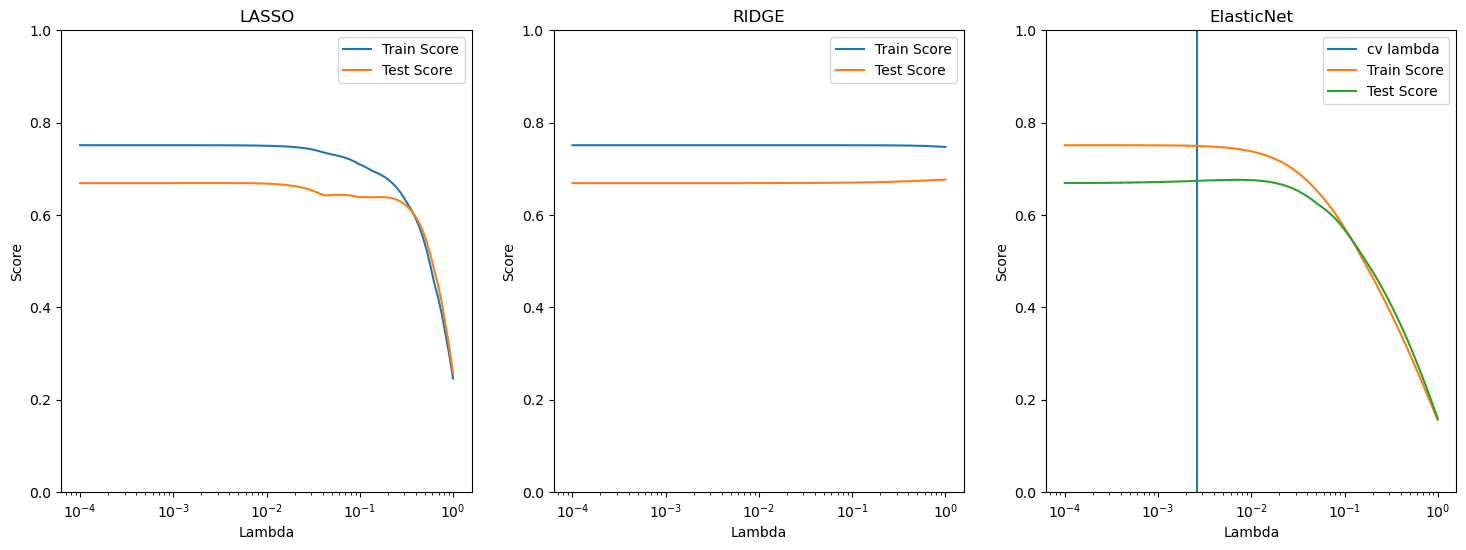

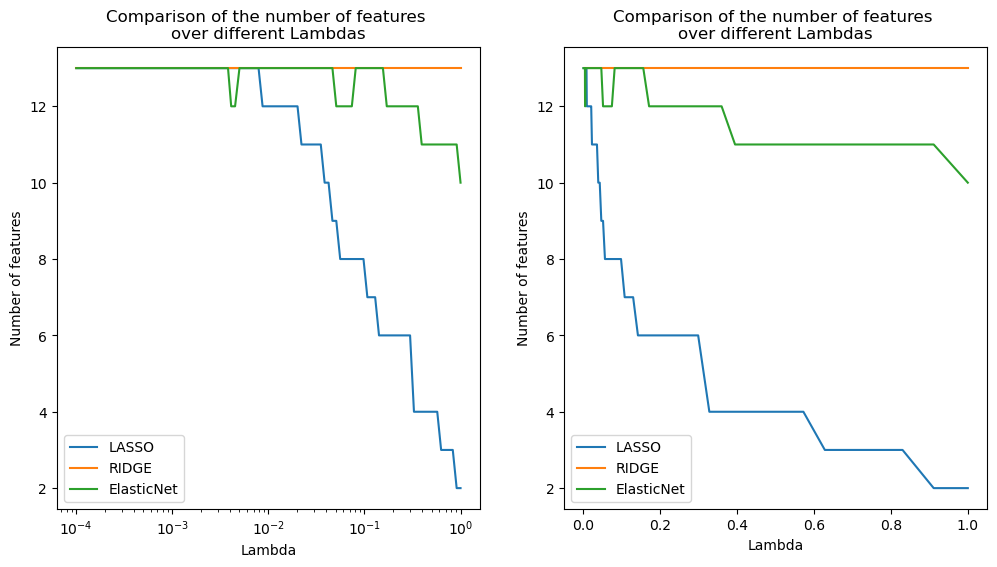

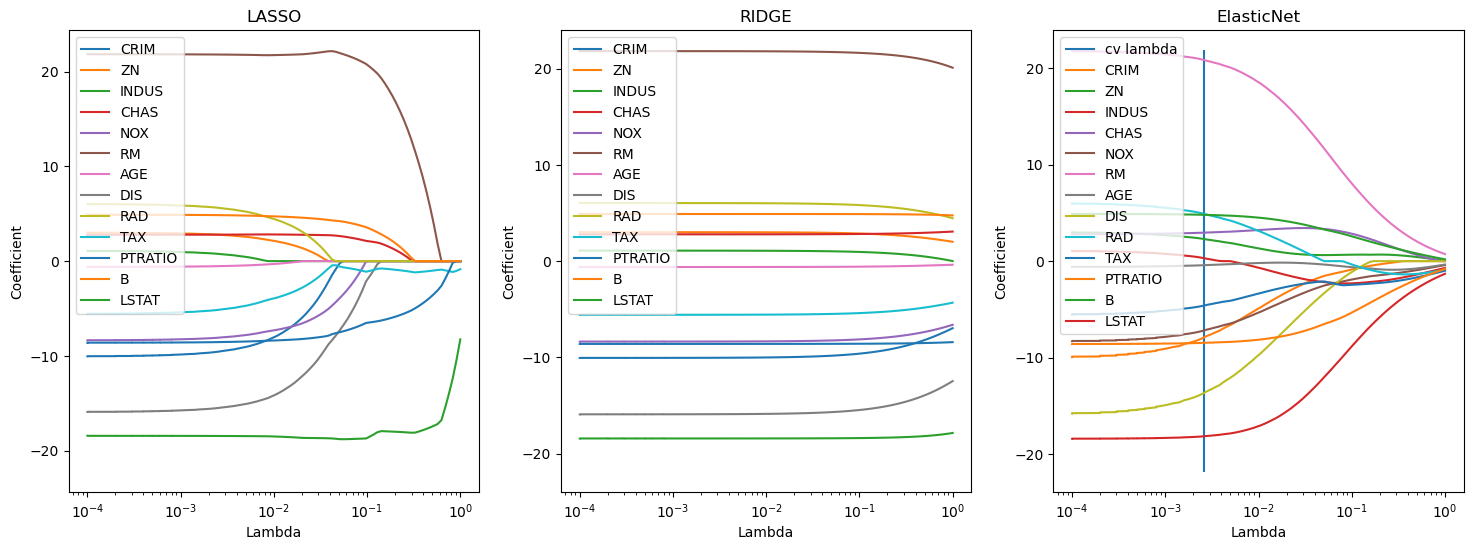

The cross validated elastic net result:
Train Score: 0.7495
Test Score: 0.6734
L1 Ratio: 0.6
Lambda: 0.0026


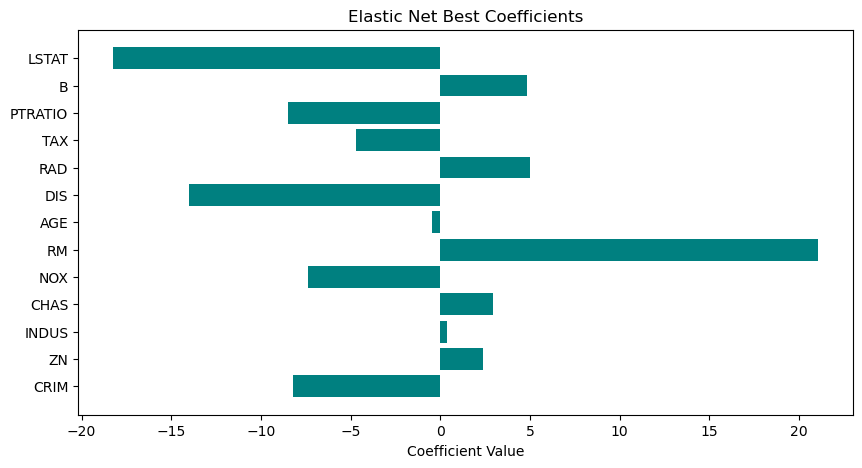

In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np
#wilt = fetch_openml('mnist_784', version=1, as_frame=True)
boston = fetch_openml('boston', version=1, as_frame=True)
X = boston.data
y = boston.target
feature_names = boston.feature_names
compare(X,y,feature_names)

An L1 ratio of 0.6 means that 60% of the regularization is L1 (lasso), favoring sparsity (setting coefficients to zero), and 40% is L2 (ridge), which tends to distribute penalties across all coefficients more evenly. This setting influences the number and values of the coefficients in the model: a higher L1 ratio increases the number of coefficients that are exactly zero, promoting a simpler, sparser model.

Lambda is the parameter that controls the overall strength of the regularization. A lower value of lambda (0.0026 in this case) suggests less aggressive regularization, allowing the model to fit more closely to the training data.

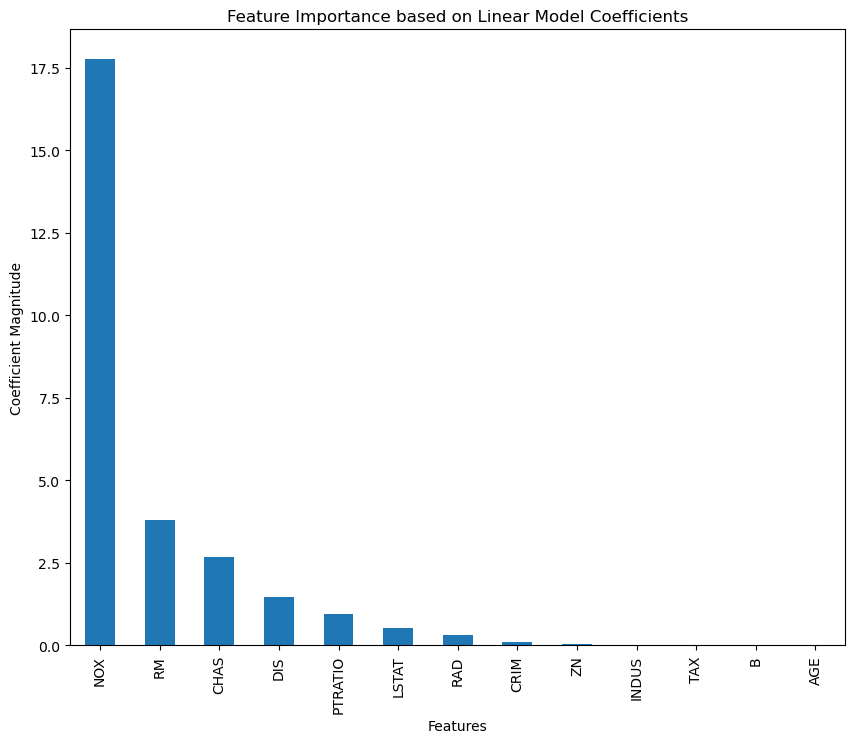

In [ ]:
important_features(X, y, feature_names)

**NOX** (Nitric Oxides concentration): The NOX feature has the largest coefficient, indicating a strong relationship with housing prices. In urban planning and environmental studies, it's well-established that higher concentrations of pollutants can decrease the desirability of an area, leading to lower property values.

**RM** (Average number of rooms per dwelling): This feature typically has a direct relationship with house prices. More rooms usually indicate more space, which directly translates to a higher price.

C:\Users\WANG-\AppData\Local\Temp\ipykernel_19956\1607509820.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


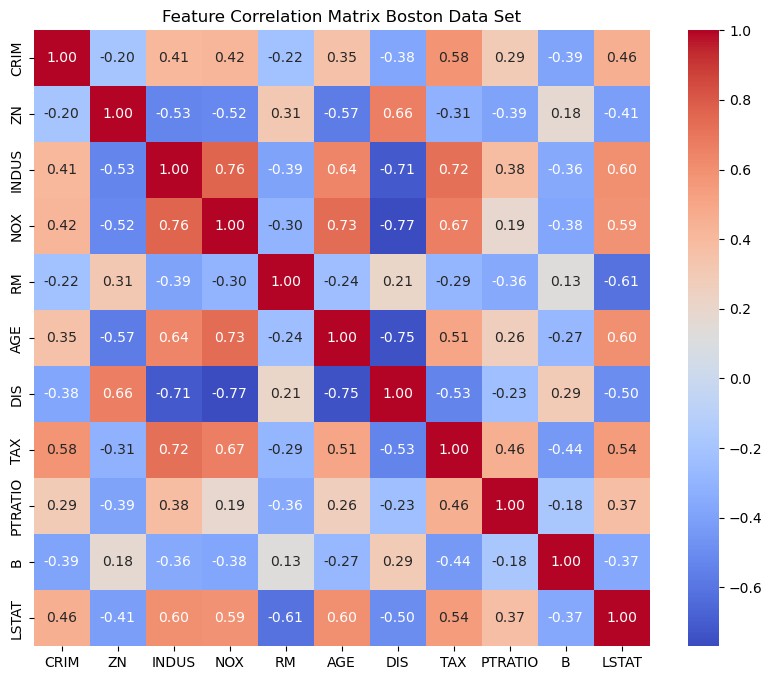

In [ ]:
### Correlation of differnet features
df_boston = boston.data
heatmap(df_boston, 'Boston Data Set')

**Potential Insights:** The matrix suggests potential relationships that could be investigated further, such as:
- A strong positive correlation between NOX and INDUS, which might suggest that as industrial activity (INDUS) increases, air pollution (NOX) also increases.
- A strong negative correlation between DIS and INDUS, which could indicate that as the distance from employment centers increases, the level of industrial activity decreases.

**Consistency with Domain Knowledge:** The correlations match what one might expect. For example, TAX (tax rate) and RAD (accessibility to highways) tend to be positively correlated as areas with better transportation infrastructure may have higher taxes.

The two most important features in linear regression are NOX and RM. But, in the Elastic Net model, the most significant coefficients are LSTAT and RM. This difference is primarily due to the correlations between these features, as demonstrated by the heatmap.